<a href="https://colab.research.google.com/github/siruku6/model_on_fer2013/blob/master/20220428_create_FER_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition

- Information on kaggle  
[Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/overview)
- Document for dataset  
[FER2013 Dataset](https://docs.activeloop.ai/datasets/fer2013-dataset)

## labels

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



# 1. install modules

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

!pip install -q pytorch_lightning

# This is necessary for `torchvision.datasets.FER2013`
!pip install torchvision==0.12


env: CUBLAS_WORKSPACE_CONFIG=:4096:8
     |████████████████████████████████| 582 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 40.7 MB/s 
     |████████████████████████████████| 136 kB 44.4 MB/s 
     |████████████████████████████████| 408 kB 45.6 MB/s 
     |████████████████████████████████| 1.1 MB 27.7 MB/s 
     |████████████████████████████████| 271 kB 14.8 MB/s 
     |████████████████████████████████| 94 kB 1.3 MB/s 
     |████████████████████████████████| 144 kB 35.8 MB/s 


In [ ]:
!pip list | grep torchvision

torchvision                   0.12.0


In [2]:
from google.colab import files
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Treating images
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

# 2. load data & create dataset

torchvisionのFER2013管理モジュール

https://pytorch.org/vision/stable/generated/torchvision.datasets.FER2013.html

In [ ]:
dir(torchvision.datasets)

In [ ]:
# uploaded = files.upload()

Saving train.csv.zip to train.csv.zip


In [5]:
!unzip "drive/MyDrive/Colab Notebooks/data/FER2013/train.csv.zip"
!mkdir fer2013
!mv train.csv fer2013/

Archive:  drive/MyDrive/Colab Notebooks/data/FER2013/train.csv.zip
  inflating: train.csv               


In [ ]:
pd.read_csv("./fer2013/train.csv").head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## normalizationのmean, stdの計算

In [ ]:
transform = transforms.Compose([
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
pre_dataset = torchvision.datasets.FER2013('./', transform=transform)
pre_dataloader = torch.utils.data.DataLoader(pre_dataset, batch_size=40, shuffle=True, drop_last=True)


In [ ]:
# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/8
mean = 0.
meansq = 0.
for data, label in tqdm(pre_dataloader):
    mean = data.mean()
    meansq = (data**2).mean()

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

# 1. 7種の表情分類　1回目

## Datasetの作成

In [4]:

transform = transforms.Compose([
    # TODO: training時のみこのtransformを適用したい
    #    要調査
    # https://medium.com/@reachraktim/emotion-recognition-on-the-fer-dataset-using-pytorch-835ce93d52a5
    transforms.RandomAffine(degrees=10),
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomResizedCrop(150, scale=(0.08, 1.0), ratio=(3 / 4, 4 / 3)),
    transforms.GaussianBlur(kernel_size=3),
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    # # PyTorch公式でもこのmean, stdが推奨されている -> 3 channels でないと使えないのでコメントアウト
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.4942], std=[0.2614])
])

dataset = torchvision.datasets.FER2013('./', transform=transform)
dataset

Dataset FER2013
    Number of datapoints: 28709
    Root location: ./
    split=train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-10.0, 10.0])
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
               ToTensor()
               Normalize(mean=[0.4942], std=[0.2614])
           )

In [ ]:
dataset[0][0]

tensor([[[-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         ...,
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906]]])

0


(-0.5, 223.5, 223.5, -0.5)

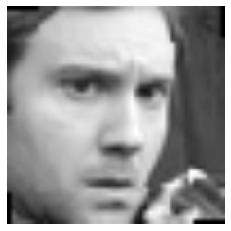

In [ ]:
print(dataset[0][1])
plt.imshow(
    dataset[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

3


(-0.5, 223.5, 223.5, -0.5)

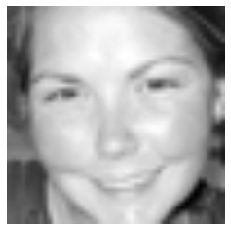

In [ ]:
print(dataset[8][1])
plt.imshow(
    dataset[8][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

In [ ]:
len(dataset)

28709

# 3. create dataloader

In [5]:
pl.seed_everything(0)

n_train = int(len(dataset) * 0.8)
n_val = int(len(dataset) * 0.1)
n_test = len(dataset) - n_train - n_val
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

batch_size = 200
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader


Global seed set to 0


6


(-0.5, 223.5, 223.5, -0.5)

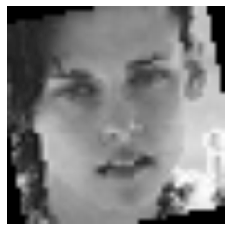

In [ ]:
print(train[0][1])
plt.imshow(
    train[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

4


(-0.5, 223.5, 223.5, -0.5)

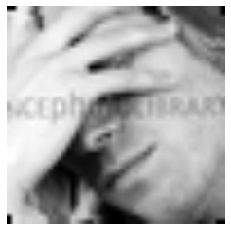

In [ ]:
print(val[0][1])
plt.imshow(
    val[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

# 4. ネットワーク構築

## ネットワーク構成要素の動作確認

In [ ]:
# test動作確認
feature = resnet18(pretrained=True)
feature

conv = nn.Conv2d(1, 3, 1, 1, (0, 0))
fc = nn.Linear(1000, 7)

h0 = conv(dataset[0][0].unsqueeze(0))
print("h0.shape: ", h0.shape)

h1 = feature(h0)
print("h0.shape: ", h1.shape)

h2 = fc(h1)
print("h0.shape: ", h2.shape)


h0.shape:  torch.Size([1, 3, 224, 224])
h0.shape:  torch.Size([1, 1000])
h0.shape:  torch.Size([1, 7])


## ネットワーク構築

In [ ]:
class ClassifyFacialExpressionNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 3, 1, 1, (0, 0))
        self.resnet = resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 7)

    def forward(self, x):
        h0 = self.conv(x)
        h1 = self.resnet(h0)
        h2 = self.fc(h1)
        return h2

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.01)
        return optimizer


# 5. 学習

## 学習実施

In [ ]:
torch.cuda.empty_cache()

gpu_on: bool = torch.cuda.is_available()
gpus: int = 1 if gpu_on else 0
gpus

pl.seed_everything(0)
c_net = ClassifyFacialExpressionNet()
logger = CSVLogger(save_dir='logs', name='facial_net')
trainer = pl.Trainer(max_epochs=10, gpus=gpus, deterministic=True, logger=logger)
trainer.fit(c_net, train_loader, val_loader)


In [ ]:
trainer.callback_metrics

{'train_acc': tensor(0.7159),
 'train_loss': tensor(0.7840),
 'val_acc': tensor(0.5995),
 'val_loss': tensor(1.1192)}

## 学習結果確認

In [ ]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/facial_net/version_0/checkpoints/epoch=9-step=860.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/facial_net/version_0/checkpoints/epoch=9-step=860.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5735714435577393
        test_loss            1.188377857208252
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5735714435577393, 'test_loss': 1.188377857208252}]

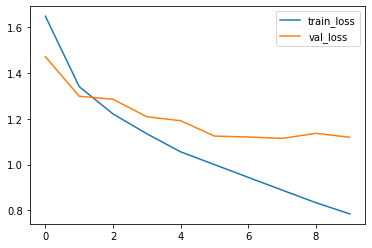

In [ ]:
# 結果確認
log = pd.read_csv('logs/facial_net/version_0/metrics.csv')

log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

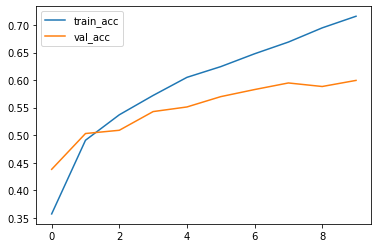

In [ ]:
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot()
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot()
plt.legend()

# 2. 7種の表情分類　2回目

## ResNetの1層目を追加するのではなく、書き換えた場合、精度はどうなるか

& mixup & エポック数２倍

https://discuss.pytorch.org/t/modify-resnet-or-vgg-for-single-channel-grayscale/22762/10

In [ ]:
class ClassifyFacialExpressionNet(pl.LightningModule):
    def __init__(self, mixup_alpha: float = None):
        super().__init__()
        model = resnet18(pretrained=True)
        # https://discuss.pytorch.org/t/modify-resnet-or-vgg-for-single-channel-grayscale/22762/14
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet = model
        self.fc = nn.Linear(1000, 7)
        self.mixup_alpha = mixup_alpha

    def forward(self, x):
        h1 = self.resnet(x)
        h2 = self.fc(h1)
        return h2

    def training_step(self, batch, batch_idx):
        x, t = batch
        if self.mixup_alpha is not None:
            x, targets_a, targets_b, lam = self._mixup_data(x, t, alpha=self.mixup_alpha)
            y = self(x)
            loss = self._mixup_criterion(F.cross_entropy, y, targets_a, targets_b, lam)
        else:
            y = self(x)
            loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.01)
        return optimizer

    ################################################################
    #   Private Methods
    ################################################################
    def _mixup_data(self, x, y, alpha=1.0):
        if alpha > 0.:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.
        batch_size = x.size()[0]
        index = torch.randperm(batch_size)

        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def _mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
torch.cuda.empty_cache()

gpu_on: bool = torch.cuda.is_available()
gpus: int = 1 if gpu_on else 0
gpus

pl.seed_everything(0)
c_net = ClassifyFacialExpressionNet(mixup_alpha=0.4)
logger = CSVLogger(save_dir='logs', name='facial_net')
trainer = pl.Trainer(max_epochs=20, gpus=gpus, deterministic=True, logger=logger)
trainer.fit(c_net, train_loader, val_loader)


Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.7 M
1 | fc     | Linear | 7.0 K 
----------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.761    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.callback_metrics

{'train_acc': tensor(0.4124),
 'train_loss': tensor(1.0762),
 'val_acc': tensor(0.6021),
 'val_loss': tensor(1.0795)}

In [ ]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/facial_net/version_1/checkpoints/epoch=19-step=1720.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/facial_net/version_1/checkpoints/epoch=19-step=1720.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5876785516738892
        test_loss           1.1165716648101807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5876785516738892, 'test_loss': 1.1165716648101807}]

In [ ]:
# モデルの保存
network_file_name = 'fer_net.pt'
torch.save(c_net.state_dict(), network_file_name)
# -> 32MB

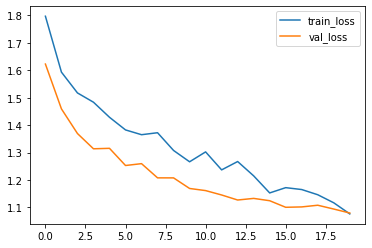

In [ ]:
# 結果確認
log = pd.read_csv('logs/facial_net/version_1/metrics.csv')

log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

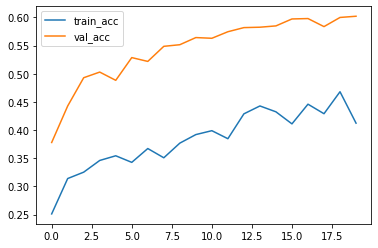

In [ ]:
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot()
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot()
plt.legend()

# 3. 7値分類問題 => 回帰問題に変換する

7種類の感情への分類ではなく、プラスの感情かマイナスの感情か（0～1）という回帰問題として扱う。

## 元のlabels

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

## 変換後の値

- 0=Angry -> 0
- 1=Disgust -> 0
- 2=Fear -> 0
- 3=Happy -> 1
- 4=Sad -> 0
- 5=Surprise -> 0.5
- 6=Neutral -> 0.5


In [ ]:
!unzip "drive/MyDrive/Colab Notebooks/data/FER2013/train.csv.zip"
!mkdir fer2013
!mv train.csv fer2013/


In [ ]:
df_raw = pd.read_csv("./fer2013/train.csv")
df_raw.head()

In [ ]:
len(df_raw[df_raw['emotion'] == 0])

3995

In [7]:
df_converted = df_raw.replace({'emotion': {1: 0, 2: 0, 3: 1, 4: 0, 5: 0.5, 6: 0.5}})
df_converted.head()

,emotion,pixels
0,0.0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0.0,151 150 147 155 148 133 111 140 170 174 182 15...
2,0.0,231 212 156 164 174 138 161 173 182 200 106 38...
3,0.0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,0.5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Converting pixes values to int

In [8]:
df_converted['pixelss']=[
    [int(y) for y in x.split()] for x in tqdm(df_converted['pixels'])
]
df_converted.head()

100%|██████████| 28709/28709 [00:27<00:00, 1055.63it/s]


,emotion,pixels,pixelss
0,0.0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0.0,151 150 147 155 148 133 111 140 170 174 182 15...,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,0.0,231 212 156 164 174 138 161 173 182 200 106 38...,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,0.0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,0.5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


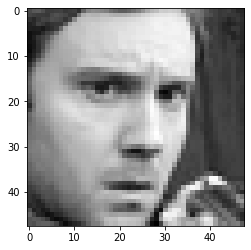

In [ ]:
z=np.array(df_converted['pixelss'][0])
zz=z.reshape(48,48)
plt.imshow(zz, interpolation='nearest',cmap='gray')
plt.show()

In [9]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df_data, transforms):
        'Initialization'
        self.transforms = transforms
        self.df_data = df_data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df_data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.df_data.iloc[index]['pixelss']
        X = np.array(X).reshape(48, 48, 1).astype(np.uint8)
        y = self.df_data.iloc[index]['emotion'].astype(np.float32)

        if self.transforms:
            X = self.transforms(X)

        X = torch.cat((X,X,X),0)
        return X, y


https://www.kaggle.com/code/balmukund/fer-2013-pytorch-implementation/notebook

https://qiita.com/dem_kk/items/bdda6079fe4dde977960

In [10]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    # TODO: training時のみこのtransformを適用したい
    #    要調査
    # https://medium.com/@reachraktim/emotion-recognition-on-the-fer-dataset-using-pytorch-835ce93d52a5
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10),
    # transforms.RandomResizedCrop(150, scale=(0.08, 1.0), ratio=(3 / 4, 4 / 3)),
    transforms.GaussianBlur(kernel_size=3),
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    # # PyTorch公式でもこのmean, stdが推奨されている -> 3 channels でないと使えないのでコメントアウト
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.4942], std=[0.2614])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4942], std=[0.2614])
])



pl.seed_everything(0)

# Raw data
n_train = int(len(df_converted) * 0.8)
n_val = int(len(df_converted) * 0.1)
n_test = len(df_converted) - n_train - n_val
df_train, df_val_test = train_test_split(df_converted, train_size=n_train)
df_val, df_test = train_test_split(df_val_test, test_size=n_test)
# train, val, test = torch.utils.data.random_split(df_converted, [n_train, n_val, n_test])

# Dataset
train_set = Dataset(df_train, train_transform)
val_set = Dataset(df_val, val_test_transform)
test_set = Dataset(df_test, val_test_transform)

# Dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader

In [ ]:
len(train_set), len(val_set)

(22967, 2870)

In [19]:
class ClassifyFacialExpressionNet(pl.LightningModule):
    def __init__(self, mixup_alpha: float = None):
        super().__init__()
        model = resnet18(pretrained=True)
        # https://discuss.pytorch.org/t/modify-resnet-or-vgg-for-single-channel-grayscale/22762/14
        # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet = model
        self.fc = nn.Linear(1000, 1)
        self.mixup_alpha = mixup_alpha

    def forward(self, x):
        h1 = self.resnet(x)
        h2 = self.fc(h1)
        return h2

    def training_step(self, batch, batch_idx):
        x, t = batch
        if self.mixup_alpha is not None:
            x, targets_a, targets_b, lam = self._mixup_data(x, t, alpha=self.mixup_alpha)
            y = self(x)
            loss = self._mixup_criterion(F.mse_loss, y, targets_a.unsqueeze(1), targets_b.unsqueeze(1), lam)
        else:
            y = self(x)
            loss = F.mse_loss(y, t.unsqueeze(1))
        root_loss = torch.sqrt(loss)
        self.log('train_loss', root_loss, on_step=False, on_epoch=True)
        # self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return root_loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.mse_loss(y, t.unsqueeze(1))
        root_loss = torch.sqrt(loss)
        self.log('val_loss', root_loss, on_step=False, on_epoch=True)
        # self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return root_loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.mse_loss(y, t.unsqueeze(1))
        root_loss = torch.sqrt(loss)
        self.log('test_loss', root_loss, on_step=False, on_epoch=True)
        # self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return root_loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.01)
        # optimizer = torch.optim.Adam(params=self.parameters(), lr=0.01, weight_decay=0.01)
        return optimizer

    ################################################################
    #   Private Methods
    ################################################################
    def _mixup_data(self, x, y, alpha=1.0):
        if alpha > 0.:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.
        batch_size = x.size()[0]
        index = torch.randperm(batch_size)

        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def _mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [32]:
# test動作確認
feature = resnet18(pretrained=True)
feature

# conv = nn.Conv2d(1, 3, 1, 1, (0, 0))
fc = nn.Linear(1000, 1)

# h0 = conv(dataset[0][0].unsqueeze(0))
# print("h0.shape: ", h0.shape)


x, t = train_set[0]
h0 = feature(x.unsqueeze(0))
print("h0.shape: ", h0.shape)

h1 = fc(h0)
print("h1.shape: ", h1.shape)

h0.shape:  torch.Size([1, 1000])
h1.shape:  torch.Size([1, 1])


In [33]:
h1

tensor([[-0.6599]], grad_fn=<AddmmBackward0>)

In [34]:
t = torch.tensor([t])
t

tensor([0.])

In [35]:
torch.sqrt(F.mse_loss(h1, t.unsqueeze(1)))


tensor(0.6599, grad_fn=<SqrtBackward0>)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


https://qiita.com/kimisyo/items/579d380b991995976f79

```python
.unsqueeze(1)
```

In [20]:
torch.cuda.empty_cache()

gpu_on: bool = torch.cuda.is_available()
gpus: int = 1 if gpu_on else 0
gpus

pl.seed_everything(0)
c_net = ClassifyFacialExpressionNet(mixup_alpha=0.4)
logger = CSVLogger(save_dir='logs', name='facial_net')
trainer = pl.Trainer(max_epochs=20, gpus=gpus, deterministic=True, logger=logger)
trainer.fit(c_net, train_loader, val_loader)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.7 M
1 | fc     | Linear | 1.0 K 
----------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.762    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [21]:
trainer.callback_metrics

{'train_loss': tensor(0.6525, device='cuda:0'),
 'val_loss': tensor(0.3697, device='cuda:0')}

In [22]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/facial_net/version_1/checkpoints/epoch=0-step=358.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/facial_net/version_1/checkpoints/epoch=0-step=358.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37740859389305115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.37740859389305115}]

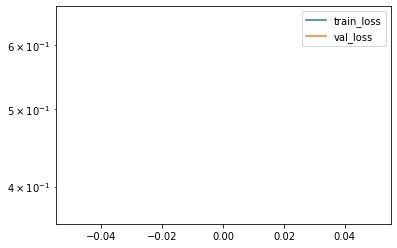

In [23]:
# 結果確認
log = pd.read_csv('logs/facial_net/version_1/metrics.csv')

log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot(logy=True)
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot(logy=True)
plt.legend()

In [ ]:
# モデルの保存
network_file_name = 'drive/MyDrive/Colab Notebooks/data/FER2013/fer_net_regression.pt'
torch.save(c_net.state_dict(), network_file_name)

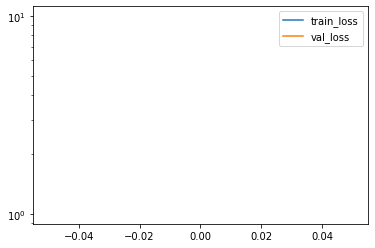

In [24]:
# 結果確認
log = pd.read_csv('logs/facial_net/version_1/metrics.csv')

log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'][1:].plot(logy=True)
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'][1:].plot(logy=True)
plt.legend()

# モデルを読み込んで推論

In [13]:
class ClassifyFacialExpressionNet(pl.LightningModule):
    def __init__(self, mixup_alpha: float = None):
        super().__init__()
        model = resnet18(pretrained=True)
        self.resnet = model
        self.fc = nn.Linear(1000, 1)
        self.mixup_alpha = mixup_alpha

    def forward(self, x):
        h1 = self.resnet(x)
        h2 = self.fc(h1)
        return h2

In [14]:
# 推論モードへの切り替え .eval()

model_file_name = 'drive/MyDrive/Colab Notebooks/data/FER2013/fer_net_regression.pt'
net = ClassifyFacialExpressionNet().cpu().eval()
net.load_state_dict(torch.load(model_file_name))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [15]:
x, t = test_set[0]
x.shape

torch.Size([3, 224, 224])

In [34]:
# 予測値の算出
with torch.no_grad():  # 重みの計算は必要ない
    # 入力データの整形: unsqueeze
    # ネットワークは、複数のサンプルがまとめて入ってくることを想定しているので、次元を一つ増やしておく
    for i in tqdm(range(10)):
        x, t = test_set[i]
        y = net(x.unsqueeze(0))
        print(f'[{i}]', 'y:', y, ' t:', t)

 10%|█         | 1/10 [00:00<00:05,  1.56it/s]

[0] y: tensor([[0.3519]])  t: 1.0


 20%|██        | 2/10 [00:01<00:04,  1.61it/s]

[1] y: tensor([[0.3727]])  t: 1.0


 30%|███       | 3/10 [00:01<00:03,  1.80it/s]

[2] y: tensor([[0.3729]])  t: 0.5


 40%|████      | 4/10 [00:02<00:03,  1.92it/s]

[3] y: tensor([[0.3736]])  t: 0.0


 50%|█████     | 5/10 [00:02<00:02,  1.99it/s]

[4] y: tensor([[0.3744]])  t: 0.0


 60%|██████    | 6/10 [00:03<00:01,  2.03it/s]

[5] y: tensor([[0.3766]])  t: 1.0


 70%|███████   | 7/10 [00:03<00:01,  2.01it/s]

[6] y: tensor([[0.3316]])  t: 0.0


 80%|████████  | 8/10 [00:04<00:01,  1.99it/s]

[7] y: tensor([[0.3478]])  t: 1.0


 90%|█████████ | 9/10 [00:04<00:00,  2.04it/s]

[8] y: tensor([[0.3755]])  t: 0.0


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

[9] y: tensor([[0.3717]])  t: 0.0


In [19]:
x

tensor([[[ 1.7849,  1.7849,  1.7849,  ...,  0.6598,  0.6748,  0.6748],
         [ 1.7849,  1.7849,  1.7849,  ...,  0.6598,  0.6748,  0.6748],
         [ 1.7849,  1.7849,  1.7849,  ...,  0.6598,  0.6748,  0.6748],
         ...,
         [-1.7106, -1.7106, -1.7106,  ...,  1.2899,  1.2899,  1.2899],
         [-1.7106, -1.7106, -1.7106,  ...,  1.2899,  1.2899,  1.2899],
         [-1.7106, -1.7106, -1.7106,  ...,  1.2899,  1.2899,  1.2899]],

        [[ 1.7849,  1.7849,  1.7849,  ...,  0.6598,  0.6748,  0.6748],
         [ 1.7849,  1.7849,  1.7849,  ...,  0.6598,  0.6748,  0.6748],
         [ 1.7849,  1.7849,  1.7849,  ...,  0.6598,  0.6748,  0.6748],
         ...,
         [-1.7106, -1.7106, -1.7106,  ...,  1.2899,  1.2899,  1.2899],
         [-1.7106, -1.7106, -1.7106,  ...,  1.2899,  1.2899,  1.2899],
         [-1.7106, -1.7106, -1.7106,  ...,  1.2899,  1.2899,  1.2899]],

        [[ 1.7849,  1.7849,  1.7849,  ...,  0.6598,  0.6748,  0.6748],
         [ 1.7849,  1.7849,  1.7849,  ...,  0

torch.Size([224, 224])

(-0.5, 223.5, 223.5, -0.5)

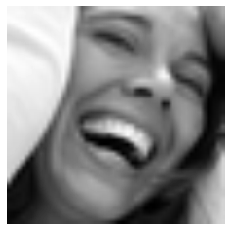

In [32]:
plt.imshow(
    test_set[0][0][0],
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

# 4. 7クラス分類問題 => 3クラス分類問題に変換する

7種類の感情への分類ではなく、プラスの感情かマイナスの感情かニュートラルの表情かという3クラス分類問題として扱う。

## 元のlabels

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

## 変換後の値

- 0=Angry -> 0
- 1=Disgust -> 0
- 2=Fear -> 0
- 3=Happy -> 2
- 4=Sad -> 0
- 5=Surprise -> 1
- 6=Neutral -> 1

In [ ]:
!unzip "drive/MyDrive/Colab Notebooks/data/FER2013/train.csv.zip"
!mkdir fer2013
!mv train.csv fer2013/


In [ ]:
df_raw = pd.read_csv("./fer2013/train.csv")
df_raw.head()

In [25]:
df_converted = df_raw.replace({'emotion': {1: 0, 2: 0, 3: 2, 4: 0, 5: 1, 6: 1}})
df_converted['pixelss']=[
    [int(y) for y in x.split()] for x in tqdm(df_converted['pixels'])
]
df_converted.head()


100%|██████████| 28709/28709 [00:19<00:00, 1492.49it/s]


,emotion,pixels,pixelss
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,0,231 212 156 164 174 138 161 173 182 200 106 38...,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,1,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [33]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df_data, transforms):
        'Initialization'
        self.transforms = transforms
        self.df_data = df_data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df_data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.df_data.iloc[index]['pixelss']
        X = np.array(X).reshape(48, 48, 1).astype(np.uint8)
        y = self.df_data.iloc[index]['emotion'] # .astype(np.float32)

        if self.transforms:
            X = self.transforms(X)

        X = torch.cat((X,X,X),0)
        return X, y


In [34]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    # TODO: training時のみこのtransformを適用したい
    #    要調査
    # https://medium.com/@reachraktim/emotion-recognition-on-the-fer-dataset-using-pytorch-835ce93d52a5
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10),
    # transforms.RandomResizedCrop(150, scale=(0.08, 1.0), ratio=(3 / 4, 4 / 3)),
    transforms.GaussianBlur(kernel_size=3),
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    # # PyTorch公式でもこのmean, stdが推奨されている -> 3 channels でないと使えないのでコメントアウト
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.4942], std=[0.2614])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4942], std=[0.2614])
])



pl.seed_everything(0)

# Raw data
n_train = int(len(df_converted) * 0.8)
n_val = int(len(df_converted) * 0.1)
n_test = len(df_converted) - n_train - n_val
df_train, df_val_test = train_test_split(df_converted, train_size=n_train)
df_val, df_test = train_test_split(df_val_test, test_size=n_test)
# train, val, test = torch.utils.data.random_split(df_converted, [n_train, n_val, n_test])

# Dataset
train_set = Dataset(df_train, train_transform)
val_set = Dataset(df_val, val_test_transform)
test_set = Dataset(df_test, val_test_transform)

# Dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader

Global seed set to 0


In [44]:
class ClassifyFacialExpressionNet(pl.LightningModule):
    def __init__(self, mixup_alpha: float = None):
        super().__init__()
        model = resnet18(pretrained=True)
        # https://discuss.pytorch.org/t/modify-resnet-or-vgg-for-single-channel-grayscale/22762/14
        # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet = model
        self.fc1 = nn.Linear(1000, 7)
        self.fc2 = nn.Linear(7, 3)
        self.mixup_alpha = mixup_alpha

    def forward(self, x):
        h1 = self.resnet(x)
        h2 = self.fc1(h1)
        h3 = self.fc2(h2)
        return h3

    def training_step(self, batch, batch_idx):
        x, t = batch
        if self.mixup_alpha is not None:
            x, targets_a, targets_b, lam = self._mixup_data(x, t, alpha=self.mixup_alpha)
            y = self(x)
            loss = self._mixup_criterion(F.cross_entropy, y, targets_a, targets_b, lam)
        else:
            y = self(x)
            loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.01)
        # optimizer = torch.optim.Adam(params=self.parameters(), lr=0.01, weight_decay=0.01)
        return optimizer

    ################################################################
    #   Private Methods
    ################################################################
    def _mixup_data(self, x, y, alpha=1.0):
        if alpha > 0.:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.
        batch_size = x.size()[0]
        index = torch.randperm(batch_size)

        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def _mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [45]:
torch.cuda.empty_cache()

gpu_on: bool = torch.cuda.is_available()
gpus: int = 1 if gpu_on else 0
gpus

pl.seed_everything(0)
c_net = ClassifyFacialExpressionNet(mixup_alpha=0.4)
logger = CSVLogger(save_dir='logs', name='facial_net')
trainer = pl.Trainer(max_epochs=20, gpus=gpus, deterministic=True, logger=logger)
trainer.fit(c_net, train_loader, val_loader)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.7 M
1 | fc1    | Linear | 7.0 K 
2 | fc2    | Linear | 24    
----------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.786    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [46]:
trainer.callback_metrics

{'train_acc': tensor(0.5899),
 'train_loss': tensor(0.5500),
 'val_acc': tensor(0.7937),
 'val_loss': tensor(0.5132)}

In [47]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/facial_net/version_6/checkpoints/epoch=19-step=7160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/facial_net/version_6/checkpoints/epoch=19-step=7160.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7887073755264282
        test_loss           0.5317931771278381
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7887073755264282, 'test_loss': 0.5317931771278381}]

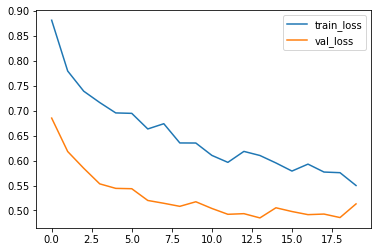

In [48]:
# 結果確認
log = pd.read_csv('logs/facial_net/version_6/metrics.csv')

log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
# log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot(logy=True)
# log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot(logy=True)
plt.legend()

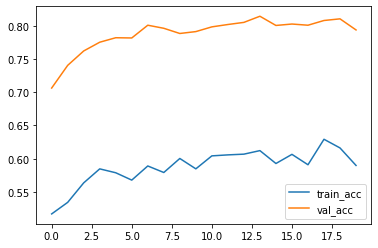

In [49]:
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot()
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot()
plt.legend()

In [50]:
# モデルの保存
network_file_name = 'drive/MyDrive/Colab Notebooks/data/FER2013/fer_net_regression.pt'
torch.save(c_net.state_dict(), network_file_name)

## モデルを読み込んで推論

In [52]:
class ClassifyFacialExpressionNet(pl.LightningModule):
    def __init__(self, mixup_alpha: float = None):
        super().__init__()
        model = resnet18(pretrained=True)

        self.resnet = model
        self.fc1 = nn.Linear(1000, 7)
        self.fc2 = nn.Linear(7, 3)
        self.mixup_alpha = mixup_alpha

    def forward(self, x):
        h1 = self.resnet(x)
        h2 = self.fc1(h1)
        h3 = self.fc2(h2)
        return h3

In [53]:
# 推論モードへの切り替え .eval()

model_file_name = 'drive/MyDrive/Colab Notebooks/data/FER2013/fer_net_regression.pt'
net = ClassifyFacialExpressionNet().cpu().eval()
net.load_state_dict(torch.load(model_file_name))

<All keys matched successfully>

In [72]:
# 予測値の算出
with torch.no_grad():  # 重みの計算は必要ない
    # 入力データの整形: unsqueeze
    # ネットワークは、複数のサンプルがまとめて入ってくることを想定しているので、次元を一つ増やしておく
    for i in tqdm(range(10)):
        x, t = test_set[i]
        y = net(x.unsqueeze(0))
        print(f'[{i}]', 'y:', y.softmax(dim=-1), ' t:', t, torch.matmul(y.softmax(dim=-1), torch.tensor([0.0,1.0,2.0])))

 20%|██        | 2/10 [00:00<00:01,  6.77it/s]

[0] y: tensor([[0.0963, 0.0309, 0.8728]])  t: 2 tensor([1.7765])
[1] y: tensor([[0.0195, 0.0137, 0.9669]])  t: 2 tensor([1.9474])


 40%|████      | 4/10 [00:00<00:00,  6.86it/s]

[2] y: tensor([[0.0879, 0.6626, 0.2495]])  t: 1 tensor([1.1616])
[3] y: tensor([[0.8227, 0.1694, 0.0079]])  t: 0 tensor([0.1852])


 60%|██████    | 6/10 [00:00<00:00,  6.58it/s]

[4] y: tensor([[0.7575, 0.1187, 0.1238]])  t: 0 tensor([0.3663])
[5] y: tensor([[0.0272, 0.0173, 0.9555]])  t: 2 tensor([1.9283])


 80%|████████  | 8/10 [00:01<00:00,  6.35it/s]

[6] y: tensor([[0.8994, 0.0884, 0.0122]])  t: 0 tensor([0.1128])
[7] y: tensor([[0.3200, 0.4178, 0.2622]])  t: 2 tensor([0.9422])


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]

[8] y: tensor([[0.1226, 0.8443, 0.0331]])  t: 0 tensor([0.9105])
[9] y: tensor([[0.7266, 0.2268, 0.0465]])  t: 0 tensor([0.3199])


100%|██████████| 10/10 [00:00<00:00, 27.59it/s]


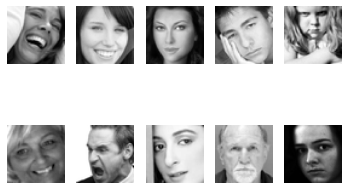

In [73]:

for i in tqdm(range(10)):
    x, _ = test_set[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        x[0],
        interpolation='nearest',
        cmap = "gray",
    )
    plt.axis('off')